In [90]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge , ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
#import seaborn as sns
import statsmodels.api as sm
'''
from keras import models, layers, optimizers
from keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Reshape, Input, merge, GlobalAveragePooling1D, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
from keras.layers.core import Lambda
from keras import backend as K'''

'\nfrom keras import models, layers, optimizers\nfrom keras.optimizers import Adam \nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Embedding, LSTM, Reshape, Input, merge, GlobalAveragePooling1D, Convolution1D, AveragePooling1D, Activation, Flatten\nfrom keras.preprocessing import sequence\nfrom keras.models import Model\nfrom keras.engine import topology\nfrom keras.layers.core import Lambda\nfrom keras import backend as K'

In [14]:
df_day = pd.read_csv("day.csv")
df_hour = pd.read_csv("hour.csv")
len(df_day)

731

In [5]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1


In [6]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**GAME PLAN** 

Let us first try to build a model for "cnt" in the daily dataset and then we can finetune things for the hourly "cnt". For the daily as well as for the hourly case, we will try to build two models: one for the "casual cnt" as well as for the "registered cnt", and then add them up later on.  

**A - daily cnt analysis**

**1. _Data preparation_**: watch out for missing values, normalize continuous features, convert categorical features to one-hot encoding via pd.get_dummies

**2. _Feature selection_**: use lasso with various paramter "alpha" (the parameter that determines how aggressively features are being pushed towards 0 - so the larger alpha is, the less features will be used with the crosseponding lasso model). segment features according to how much leverage they have on each label (casual as well as registered): high leverage features, medium leverage features, low leverage features. then build intuition through various plots.

**3. _Model testing_**: based on previous plots, run some basic models such as ridge regression, kNN regression, random forest, gradient boosting for the "casual cnt" as well as for the "registered cnt". We test various hyperparameter for their respective performance. We expect the "registered cnt" to be more predictable (by common sense). If we feel the need to be a little more fancy we can try some Poisson models, non-negative binomials or time series analysis. 

**4. _Outlier removal_**: if we are still unhappy we can perform some outlier removal such as storm sandy hitting DC at the end of october 2012. then test performance for the so far best performing model.

**5. _Feature augmentation_**: If we are still unhappy we want to think of some feature augmentation, such as pulling data for **daylight timespan** for the daily cnt, or the **sunrise/ sunset data**, or rely on other expert knowledge. To see how relevant those features are, we can perform lasso again for various "alpha" values. then test performance for the so far best performing model. 

**6. _Clustering_**: apply differnet models for different party of the data. then test performance for the so far best performing model.  

All intermediate evaluations will be done using 3-fold cross validation. once we have a winner, we will do the random test selection evaluation of size 0.1

**B - hourly cnt analysis**

**1. _Data preparation_**: prepare the data: watch out for missing values, normalize continuous features, convert categorical features to one-hot encoding via pd.get_dummies

**2. _Feature selection_**: use lasso with various paramter "alpha". segment features according to how much leverage they have on each label (casual as well as registered), then build intuition through various plots.

**3. _Model testing_ **

**4. _Outlier removal_**

**5. _Feature augmentation_** here **sunrise/ sunset data** can be interesting

**6. _Clustering_**

# A - DAILY ANALYSIS

## A1 - Data preparation  

In [15]:
df_day.columns 

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**continuous features**: 'temp', 'atemp', 'hum', 'windspeed'

**categorical features**: 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',

## transforming categorical features

In [16]:
df_day['season'].unique()

array([1, 2, 3, 4])

In [17]:
dummies_season = pd.get_dummies(df_day['season']).rename(columns={1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"})

In [18]:
dummies_season.head()

,Spring,Summer,Fall,Winter
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [19]:
df_day['yr'].unique()

array([0, 1])

In [20]:
dummies_yr = pd.get_dummies(df_day['yr']).rename(columns={0: "year 2011", 1: "year 2012"})

In [21]:
dummies_yr.head()

,year 2011,year 2012
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [22]:
df_day['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
dummies_mnth = pd.get_dummies(df_day['mnth']).rename(columns={1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})

In [24]:
dummies_mnth.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [25]:
df_day['holiday'].unique()

array([0, 1])

In [26]:
df_day['holiday'].sum() # ok so 1 is holiday and 0 is no holiday

21

In [27]:
df_day['weekday'].unique()

array([6, 0, 1, 2, 3, 4, 5])

In [28]:
df_day[df_day['dteday']=='2011-01-01']['weekday'] # Jan 1, 2011 was a Saturday so 6 is Saturday.

0    6
Name: weekday, dtype: int64

In [29]:
df_day['workingday'].unique()

array([0, 1])

In [30]:
df_day['workingday'].sum() # so 1 is workings day, and 0 is non workingday

500

In [31]:
df_day['weathersit'].unique() # huh? no weathersit 4?  

array([2, 1, 3])

In [32]:
dummies_holiday = pd.get_dummies(df_day['holiday']).rename(columns={0: "holiday", 1: "non holiday"})
dummies_weekday = pd.get_dummies(df_day['weekday']).rename(columns={0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"})
dummies_workingday = pd.get_dummies(df_day['workingday']).rename(columns={0: "workingday", 1: "non workingday"})
dummies_weathersit = pd.get_dummies(df_day['weathersit']).rename(columns={1: "weathersit 1", 2: "weathersit 2", 3: "weathersit 3", 4: "weathersit 4"})

## bringing it all together 

In [78]:
X_day = pd.concat([df_day[['temp', 'atemp', 'hum', 'windspeed']], dummies_season, dummies_yr, dummies_mnth, dummies_holiday, dummies_weekday, dummies_workingday, dummies_weathersit], axis=1)

In [79]:
X_day.head() # here we see 36 features in total. now is time to use lasso and see the most relevant features. 

,temp,atemp,hum,windspeed,Spring,Summer,Fall,Winter,year 2011,year 2012,...,Tuesday,Wednesday,Thursday,Friday,Saturday,workingday,non workingday,weathersit 1,weathersit 2,weathersit 3
0,0.344167,0.363625,0.805833,0.160446,1,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
1,0.363478,0.353739,0.696087,0.248539,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,0.200000,0.212122,0.590435,0.160296,1,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
4,0.226957,0.229270,0.436957,0.186900,1,0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0


In [80]:
# the labels
y_day = df_day['cnt']
y_day_reg = df_day['registered']
y_day_cas = df_day['casual']
y_day.head()

0     985
1     801
2    1349
3    1562
4    1600
Name: cnt, dtype: int64

In [98]:
#train test split
#new_index = np.random.permutation(X_day.index)
#X_day = X_day.reindex(new_index)
#y_day = y_day.reindex(new_index)

X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(X_day,y_day, test_size=0.2, random_state=42)
lasso_100 = Lasso(alpha=0.1,max_iter = 1000000).fit(X_day_train,y_day_train)
print("alpha = 100 - training set score: %.2f" % lasso_100.score(X_day_train,y_day_train))
print("alpha = 100 - test set score: %.2f" % lasso_100.score(X_day_test,y_day_test))

clf =RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, min_samples_split=2)
myfit = clf.fit(X_day_train,y_day_train)
print(myfit.score(X_day_train,y_day_train))
print(myfit.score(X_day_test,y_day_test))

alpha = 100 - training set score: 0.85
alpha = 100 - test set score: 0.84
0.982235133583
0.885121357565


In [88]:
# lasso for the total cnt number

lasso_100 = Lasso(alpha=100,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_10 = Lasso(alpha=10,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_1 = Lasso(alpha=1,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_01 = Lasso(alpha=0.1,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_001 = Lasso(alpha=0.01,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_0001 = Lasso(alpha=0.001,max_iter = 1000000).fit(X_day_train,y_day_train)

print("alpha = 100 - training set score: %.2f" % lasso_100.score(X_day_train,y_day_train))
print("alpha = 100 - test set score: %.2f" % lasso_100.score(X_day_test,y_day_test))
print("alpha = 100 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_100.predict(X_day_test)))
print("alpha = 100 - number of features used: %d" % np.sum(lasso_100.coef_ !=0))
print("alpha = 100 - features at play:", X_day.columns[lasso_100.coef_ !=0])
print("alpha = 100 - corresponding coefficients: ", lasso_100.coef_[lasso_100.coef_ !=0])
print("---------------------------")
print("alpha = 10 - training set score: %.2f" % lasso_10.score(X_day_train,y_day_train))
print("alpha = 10 - test set score: %.2f" % lasso_10.score(X_day_test,y_day_test))
print("alpha = 10 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_10.predict(X_day_test)))
print("alpha = 10 - number of features used: %d" % np.sum(lasso_10.coef_ !=0))
print("alpha = 10 - features at play:", X_day.columns[lasso_10.coef_ !=0])
print("alpha = 10 - corresponding coefficients: ", lasso_10.coef_[lasso_10.coef_ !=0])
print("---------------------------")
print("alpha = 1 - training set score: %.2f" % lasso_1.score(X_day_train,y_day_train))
print("alpha = 1 - test set score: %.2f" % lasso_1.score(X_day_test,y_day_test))
print("alpha = 1 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_1.predict(X_day_test)))
print("alpha = 1 - number of features used: %d" % np.sum(lasso_1.coef_ !=0))
print("alpha = 1 - features at play:", X_day.columns[lasso_1.coef_ !=0])
print("alpha = 1 - corresponding coefficients: ", lasso_1.coef_[lasso_1.coef_ !=0])
print("---------------------------")
print("alpha = 0.1 - training set score: %.2f" % lasso_01.score(X_day_train,y_day_train))
print("alpha = 0.1 - test set score: %.2f" % lasso_01.score(X_day_test,y_day_test))
print("alpha = 0.1 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_01.predict(X_day_test)))
print("alpha = 0.1 - number of features used: %d" % np.sum(lasso_01.coef_ !=0))
print("alpha = 0.1 - features at play:", X_day.columns[lasso_01.coef_ !=0])
print("alpha = 0.1 - corresponding coefficients: ", lasso_01.coef_[lasso_01.coef_ !=0])
print("---------------------------")
print("alpha = 0.01 - training set score: %.2f" % lasso_001.score(X_day_train,y_day_train))
print("alpha = 0.01 - test set score: %.2f" % lasso_001.score(X_day_test,y_day_test))
print("alpha = 0.01 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_001.predict(X_day_test)))
print("alpha = 0.01 - number of features used: %d" % np.sum(lasso_001.coef_ !=0))
print("alpha = 0.01 - features at play:", X_day.columns[lasso_001.coef_ !=0])
print("alpha = 0.01 - corresponding coefficients: ", lasso_001.coef_[lasso_001.coef_ !=0])
print("---------------------------")
print("alpha = 0.001 - training set score: %.2f" % lasso_0001.score(X_day_train,y_day_train))
print("alpha = 0.001 - test set score: %.2f" % lasso_0001.score(X_day_test,y_day_test))
print("alpha = 0.001 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_0001.predict(X_day_test)))
print("alpha = 0.001 - number of features used: %d" % np.sum(lasso_0001.coef_ !=0))
print("alpha = 0.001 - features at play:", X_day.columns[lasso_0001.coef_ !=0])
print("alpha = 0.001 - corresponding coefficients: ", lasso_0001.coef_[lasso_0001.coef_ !=0])

alpha = 100 - training set score: 0.67
alpha = 100 - test set score: 0.69
alpha = 100 - test set MAE: 834.25
alpha = 100 - number of features used: 6
alpha = 100 - features at play: Index(['temp', 'Spring', 'Fall', 'year 2011', 'year 2012', 'weathersit 1'], dtype='object')
alpha = 100 - corresponding coefficients:  [  2.85721268e+02  -1.84118901e+03   3.45990631e+02  -1.66643822e+03
   9.61348246e-13   5.09135705e+02]
---------------------------
alpha = 10 - training set score: 0.83
alpha = 10 - test set score: 0.82
alpha = 10 - test set MAE: 625.03
alpha = 10 - number of features used: 22
alpha = 10 - features at play: Index(['temp', 'atemp', 'Spring', 'Winter', 'year 2011', 'year 2012', 'Jan',
       'Mar', 'May', 'Jul', 'Sep', 'Oct', 'Nov', 'Dec', 'holiday', 'Sunday',
       'Monday', 'Tuesday', 'Thursday', 'Saturday', 'weathersit 1',
       'weathersit 3'],
      dtype='object')
alpha = 10 - corresponding coefficients:  [  1.17974410e+03   3.04558450e+03  -1.27254191e+03   2.228824

In [ ]:
lasso_100 = Lasso(alpha=100,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_10 = Lasso(alpha=10,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_1 = Lasso(alpha=1,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_01 = Lasso(alpha=0.1,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_001 = Lasso(alpha=0.01,max_iter = 1000000).fit(X_day_train,y_day_train)
lasso_0001 = Lasso(alpha=0.001,max_iter = 1000000).fit(X_day_train,y_day_train)

print("alpha = 100 - training set score: %.2f" % lasso_100.score(X_day_train,y_day_train))
print("alpha = 100 - test set score: %.2f" % lasso_100.score(X_day_test,y_day_test))
print("alpha = 100 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_100.predict(X_day_test)))
print("alpha = 100 - number of features used: %d" % np.sum(lasso_100.coef_ !=0))
print("alpha = 100 - features at play:", X_day.columns[lasso_100.coef_ !=0])
print("alpha = 100 - corresponding coefficients: ", lasso_100.coef_[lasso_100.coef_ !=0])
print("---------------------------")
print("alpha = 10 - training set score: %.2f" % lasso_10.score(X_day_train,y_day_train))
print("alpha = 10 - test set score: %.2f" % lasso_10.score(X_day_test,y_day_test))
print("alpha = 10 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_10.predict(X_day_test)))
print("alpha = 10 - number of features used: %d" % np.sum(lasso_10.coef_ !=0))
print("alpha = 10 - features at play:", X_day.columns[lasso_10.coef_ !=0])
print("alpha = 10 - corresponding coefficients: ", lasso_10.coef_[lasso_10.coef_ !=0])
print("---------------------------")
print("alpha = 1 - training set score: %.2f" % lasso_1.score(X_day_train,y_day_train))
print("alpha = 1 - test set score: %.2f" % lasso_1.score(X_day_test,y_day_test))
print("alpha = 1 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_1.predict(X_day_test)))
print("alpha = 1 - number of features used: %d" % np.sum(lasso_1.coef_ !=0))
print("alpha = 1 - features at play:", X_day.columns[lasso_1.coef_ !=0])
print("alpha = 1 - corresponding coefficients: ", lasso_1.coef_[lasso_1.coef_ !=0])
print("---------------------------")
print("alpha = 0.1 - training set score: %.2f" % lasso_01.score(X_day_train,y_day_train))
print("alpha = 0.1 - test set score: %.2f" % lasso_01.score(X_day_test,y_day_test))
print("alpha = 0.1 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_01.predict(X_day_test)))
print("alpha = 0.1 - number of features used: %d" % np.sum(lasso_01.coef_ !=0))
print("alpha = 0.1 - features at play:", X_day.columns[lasso_01.coef_ !=0])
print("alpha = 0.1 - corresponding coefficients: ", lasso_01.coef_[lasso_01.coef_ !=0])
print("---------------------------")
print("alpha = 0.01 - training set score: %.2f" % lasso_001.score(X_day_train,y_day_train))
print("alpha = 0.01 - test set score: %.2f" % lasso_001.score(X_day_test,y_day_test))
print("alpha = 0.01 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_001.predict(X_day_test)))
print("alpha = 0.01 - number of features used: %d" % np.sum(lasso_001.coef_ !=0))
print("alpha = 0.01 - features at play:", X_day.columns[lasso_001.coef_ !=0])
print("alpha = 0.01 - corresponding coefficients: ", lasso_001.coef_[lasso_001.coef_ !=0])
print("---------------------------")
print("alpha = 0.001 - training set score: %.2f" % lasso_0001.score(X_day_train,y_day_train))
print("alpha = 0.001 - test set score: %.2f" % lasso_0001.score(X_day_test,y_day_test))
print("alpha = 0.001 - test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_0001.predict(X_day_test)))
print("alpha = 0.001 - number of features used: %d" % np.sum(lasso_0001.coef_ !=0))
print("alpha = 0.001 - features at play:", X_day.columns[lasso_0001.coef_ !=0])
print("alpha = 0.001 - corresponding coefficients: ", lasso_0001.coef_[lasso_0001.coef_ !=0])

In [99]:
sunrise_sunset_2011 = pd.read_table('sunrise_sunset_2011.txt', delim_whitespace=True)
# source: http://aa.usno.navy.mil/data/docs/RS_OneYear.php 

OSError: File b'sunrise_sunset_2011.txt' does not exist

In [66]:
sunrise_sunset_2011.head()

NameError: name 'sunrise_sunset_2011' is not defined

# Getting to know the data 

## daily cnt analysis 

In [4]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


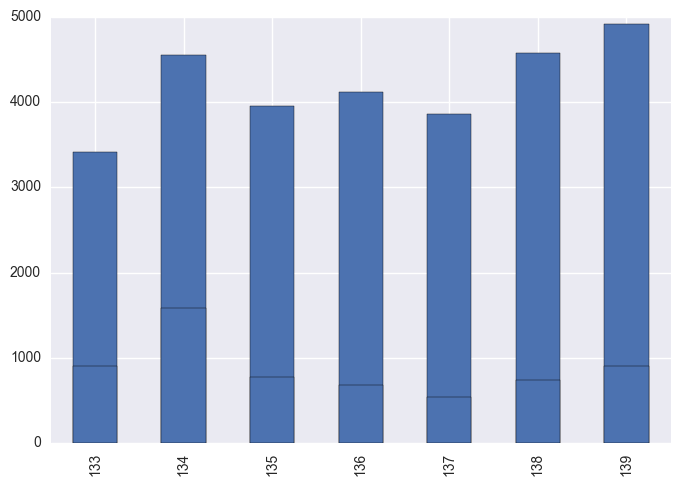

In [8]:
week = 19
df_day['cnt'][7*week:7*week+ 7].plot(kind='bar')
df_day['casual'][7*week:7*week+ 7].plot(kind='bar')

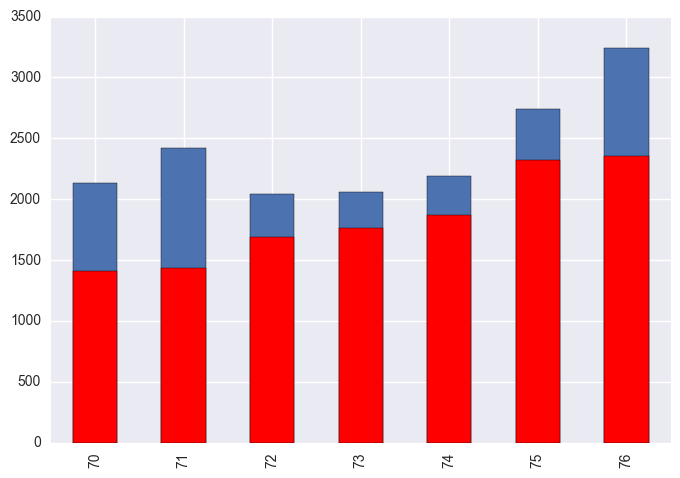

In [25]:
week = 10
df_day['cnt'][7*week:7*week+ 7].plot(kind='bar')
df_day['registered'][7*week:7*week+ 7].plot(kind='bar', color='r')

## daily casual cnt 

In [33]:
X_day= pd.concat([ df_day[['temp','atemp','hum','windspeed']],pd.get_dummies(df_day['season']), pd.get_dummies(df_day['yr']),pd.get_dummies(df_day['mnth']), pd.get_dummies(df_day['holiday']),pd.get_dummies(df_day['weekday']),pd.get_dummies(df_day['workingday']), pd.get_dummies(df_day['weathersit'])], axis=1)
y_day_cas = df_day['casual']
X_day_cas_train, X_day_cas_test, y_day_cas_train, y_day_cas_test = train_test_split(X_day,y_day_cas, test_size=0.1, random_state=42)

In [34]:
lasso_day_cas = Lasso(alpha=100,max_iter = 1000000).fit(X_day_cas_train,y_day_cas_train)
print("training set score: %.2f" % lasso_day_cas.score(X_day_cas_train,y_day_cas_train))
print("test set score: %.2f" % lasso_day_cas.score(X_day_cas_test,y_day_cas_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_cas_test, lasso_day_cas.predict(X_day_cas_test)))
print("number of features used: %d" % np.sum(lasso_day_cas.coef_ !=0))

training set score: 0.25
test set score: 0.25
test set MAE: 453.82
number of features used: 2


In [35]:
lasso_day_cas.coef_

array([   0.        ,    0.        ,   -0.        ,   -0.        ,
       -154.75609567,    0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        ,   -0.        ,
         -0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
         -0.        ,   -0.        ,    0.        ,   -0.        ,
          0.        ,   -0.        ,   -0.        ,   -0.        ,
         -0.        ,   -0.        ,    0.        ,  312.52962385,
         -0.        ,    0.        ,   -0.        ,   -0.        ])

In [36]:
X_day.columns

Index([     'temp',     'atemp',       'hum', 'windspeed',           1,
                 2,           3,           4,           0,           1,
                 1,           2,           3,           4,           5,
                 6,           7,           8,           9,          10,
                11,          12,           0,           1,           0,
                 1,           2,           3,           4,           5,
                 6,           0,           1,           1,           2,
                 3],
      dtype='object')

In [37]:
X_day.columns[lasso_day_cas.coef_ != 0] # relevant features: workingday > season 1

Index([1, 0], dtype='object')

In [38]:
lasso_day_cas = Lasso(alpha=10,max_iter = 1000000).fit(X_day_cas_train,y_day_cas_train)
print("training set score: %.2f" % lasso_day_cas.score(X_day_cas_train,y_day_cas_train))
print("test set score: %.2f" % lasso_day_cas.score(X_day_cas_test,y_day_cas_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_cas_test, lasso_day_cas.predict(X_day_cas_test)))
print("number of features used: %d" % np.sum(lasso_day_cas.coef_ !=0))

training set score: 0.69
test set score: 0.72
test set MAE: 281.13
number of features used: 14


In [43]:
X_day.columns[lasso_day_cas.coef_ != 0]

Index([     'temp',     'atemp',       'hum', 'windspeed',           1,
                 2,           4,           0,           1,           2,
                 3,           4,           5,           6,           7,
                 8,           9,          10,          12,           0,
                 1,           0,           1,           2,           3,
                 4,           5,           6,           0,           1,
                 1,           2,           3],
      dtype='object')

In [42]:
lasso_day_cas = Lasso(alpha=0.001,max_iter = 1000000).fit(X_day_cas_train,y_day_cas_train)
print("training set score: %.2f" % lasso_day_cas.score(X_day_cas_train,y_day_cas_train))
print("test set score: %.2f" % lasso_day_cas.score(X_day_cas_test,y_day_cas_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_cas_test, lasso_day_cas.predict(X_day_cas_test)))
print("number of features used: %d" % np.sum(lasso_day_cas.coef_ !=0))

training set score: 0.75
test set score: 0.72
test set MAE: 253.25
number of features used: 33


In [50]:
rfr_day_cas = RandomForestRegressor()
rfr_day_cas.fit(X_day_cas_train,y_day_cas_train)
print("training set score: %.2f" % rfr_day_cas.score(X_day_cas_train,y_day_cas_train))
print("test set score: %.3f" % rfr_day_cas.score(X_day_cas_test,y_day_cas_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_cas_test, rfr_day_cas.predict(X_day_cas_test)))

training set score: 0.97
test set score: 0.761
test set MAE: 211.70


In [54]:
gbr_day_cas = GradientBoostingRegressor()
gbr_day_cas.fit(X_day_cas_train,y_day_cas_train)
print("training set score: %.2f" % gbr_day_cas.score(X_day_cas_train,y_day_cas_train))
print("test set score: %.3f" % gbr_day_cas.score(X_day_cas_test,y_day_cas_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_cas_test, gbr_day_cas.predict(X_day_cas_test)))

training set score: 0.94
test set score: 0.783
test set MAE: 191.86


# registered daily cnt 

In [101]:
y_day_reg = df_day['registered']
X_day_reg_train, X_day_reg_test, y_day_reg_train, y_day_reg_test = train_test_split(X_day,y_day_reg, test_size=0.1, random_state=42)

In [103]:
def print_accuracy(model, X_train, y_train, X_test, y_test):
    print("training set score: %.2f" % model.score(X_train, y_train))
    print("test set score: %.2f" % model.score(X_test, y_test))
    print("test set MAE: %.2f" % mean_absolute_error(y_test, model.predict(X_test)))

    
lasso_day_reg = Lasso(alpha=0.001,max_iter = 1000000).fit(X_day_reg_train,y_day_reg_train)
print_accuracy(lasso_day_reg, X_day_reg_train, y_day_reg_train, X_day_reg_test, y_day_reg_test)


#print("training set score: %.2f" % lasso_day_reg.score(X_day_reg_train,y_day_reg_train))
#print("test set score: %.2f" % lasso_day_reg.score(X_day_reg_test,y_day_reg_test))
#print("test set MAE: %.2f" % mean_absolute_error(y_day_reg_test, lasso_day_reg.predict(X_day_reg_test)))
#print("number of features used: %d" % np.sum(lasso_day_reg.coef_ !=0))



training set score: 0.85
test set score: 0.88
test set MAE: 444.23


In [56]:
gbr_day_reg = GradientBoostingRegressor()
gbr_day_reg.fit(X_day_reg_train,y_day_reg_train)
print("training set score: %.2f" % gbr_day_reg.score(X_day_reg_train,y_day_reg_train))
print("test set score: %.3f" % gbr_day_reg.score(X_day_reg_test,y_day_reg_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_reg_test, gbr_day_reg.predict(X_day_reg_test)))

training set score: 0.95
test set score: 0.943
test set MAE: 315.20


# all daily cnt 

In [59]:
y_day = df_day['cnt']
X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(X_day,y_day, test_size=0.1, random_state=42)

In [61]:
lasso_day = Lasso(alpha=0.001,max_iter = 1000000).fit(X_day_train,y_day_train)
print("training set score: %.2f" % lasso_day.score(X_day_train,y_day_train))
print("test set score: %.2f" % lasso_day.score(X_day_test,y_day_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_test, lasso_day.predict(X_day_test)))
print("number of features used: %d" % np.sum(lasso_day.coef_ !=0))

training set score: 0.85
test set score: 0.86
test set MAE: 592.29
number of features used: 32


In [62]:
gbr_day = GradientBoostingRegressor()
gbr_day.fit(X_day_train,y_day_train)
print("training set score: %.2f" % gbr_day.score(X_day_train,y_day_train))
print("test set score: %.3f" % gbr_day.score(X_day_test,y_day_test))
print("test set MAE: %.2f" % mean_absolute_error(y_day_test, gbr_day.predict(X_day_test)))

training set score: 0.95
test set score: 0.919
test set MAE: 439.47


In [74]:
len(X_day_train)

657

In [75]:

np.absolute(gbr_day.predict(X_day_train)-y_day_train).nlargest(66)

499    1944.498534
668    1724.493461
517    1691.483617
596    1525.640483
692    1457.098224
455    1350.193286
645    1326.988826
473    1319.204362
441    1297.587272
80     1217.478926
680    1207.862376
424    1203.357369
396    1164.921650
461    1142.214143
494    1075.653257
694    1068.365973
101    1055.692815
365    1005.790568
425    1004.424619
435     979.902031
234     977.106689
452     963.444507
691     945.891619
103     907.704832
664     897.207973
670     882.726038
229     873.840289
447     859.832871
705     851.745737
708     849.155949
          ...     
48      807.985400
571     796.853979
665     795.730624
88      781.517424
656     774.778544
651     769.139831
454     758.022718
649     754.626636
358     749.427183
431     739.446804
363     736.102596
184     736.006473
26      732.134993
354     725.165744
214     724.318790
273     713.106706
498     712.852744
508     709.193741
426     701.739193
251     699.201750
142     697.551797
568     689.

In [76]:
df_day['dteday'][499]

'2012-05-14'

In [67]:
print("test set MAE: %.2f" % mean_absolute_error(y_day_test, gbr_day_cas.predict(X_day_test)+gbr_day_reg.predict(X_day_test)))

test set MAE: 417.47


# Conclusion

In [84]:
X_day.shape

(731, 36)

In [93]:
X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(X_day,y_day, test_size=0.1, random_state=42)

In [134]:
nn = Sequential()
nn.add(Dense(100, input_dim=36,init='glorot_uniform', activation='relu'))
nn.add(Dense(100, init='glorot_uniform', activation='relu'))
nn.add(Dense(10, init='glorot_uniform', activation='relu'))
nn.add(Dense(10, init='glorot_uniform', activation='relu'))
#nn.add(Dropout(dropout_probability))
nn.add(Dense(1, init='glorot_uniform', activation='relu'))
nn.compile(optimizer = 'adam', loss='mean_squared_error')

In [135]:
len(X_day_train )

657

In [136]:
n_epochs = 100
MAE = []
for epoch in range(n_epochs):
    nn.fit(np.array(X_day_train), y_day_train, nb_epoch=1, batch_size=5)
    MAE.append(mean_absolute_error(y_day_test,nn.predict(np.array(X_day_test))))
    print("performance:", mean_absolute_error(y_day_train,nn.predict(np.array(X_day_train))),mean_absolute_error(y_day_test,nn.predict(np.array(X_day_test))),epoch)

Epoch 1/1
657/657 [==============================] - 0s - loss: 21556280.5209     
performance: 2722.17162603 2764.31122156 0
Epoch 1/1
657/657 [==============================] - 0s - loss: 3289367.3660     
performance: 1159.25038906 1307.9395389 1
Epoch 1/1
657/657 [==============================] - 0s - loss: 1663170.2336     
performance: 895.757363237 978.910469674 2
Epoch 1/1
657/657 [==============================] - 0s - loss: 1090558.1169     
performance: 709.758679441 765.633726378 3
Epoch 1/1
657/657 [==============================] - 0s - loss: 829571.9980     
performance: 625.73405784 668.443839408 4
Epoch 1/1
657/657 [==============================] - 0s - loss: 739321.8815     
performance: 601.026419026 636.794544117 5
Epoch 1/1
657/657 [==============================] - 0s - loss: 707740.3938     
performance: 581.002315063 603.883839375 6
Epoch 1/1
657/657 [==============================] - 0s - loss: 678981.9550     
performance: 572.513022877 597.762343123 7
Epoch

In [145]:
sequence = Sequential()
lstm_layer = LSTM(15, input_dim=36)(sequence)
output = Dense(1, init='glorot_uniform', activation = 'relu')(lstm_layer)
lstm = Model(input = sequence, output = output)
lstm.compile(optimizer = 'adam', loss='mean_absolute_error')

TypeError: Input() got an unexpected keyword argument 'input_dim'

In [146]:
lstm = Sequential()
lstm.add(LSTM(15, input_dim=36))
lstm.add(Dense(1, init='glorot_uniform', activation = 'relu'))
lstm.compile(optimizer = 'adam', loss='mean_absolute_error')

In [148]:
n_epochs = 100
MAE = []
for epoch in range(n_epochs):
    lstm.fit(np.array(X_day_train), y_day_train, nb_epoch=1, batch_size=5)
    MAE.append(mean_absolute_error(y_day_test,lstm.predict(np.array(X_day_test))))

Exception: Error when checking model input: expected lstm_input_1 to have 3 dimensions, but got array with shape (657, 1)